# Capstone Project - Vechile Collision Severity Case Study
### Applied Data Science Capstone by IBM/Coursera



## Table of contents
* [Business Understanding](#business)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Business Understanding:

The purpose of this case study is to create a model that that can predict the potential severity of a vehicle collision based on weather and road conditions. The goal of such a model would be to evaluate the current driving condition, so that drivers can be warned to drive more carefully.



## Data Understanding:

To perform this analysis, the Seattle Collision dataset will be used. The location and vehicle specific information will be ignored for the purposes of this use case. This is because the goal is determine driving conditions based on weather and road conditions data, not individual driver behaviour or specific problematic intersections. As a result, the date, road condition, weather, and light condition will be used as input features.  To remove possible driver error as a collision factor, data points where the driver was speeding, intoxicated, or inattentive will be removed.   Finally, the collision date will be kept and used for modelling. The purpose of keeping temporal data is to capture any seasonality which may be present in the data.  

In [26]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import wandb

## Methodology

### Data Preparation:

To prepare the data for modeling, the dataset will be read into a pandas dataframe. Then, the attributes that were deemed unnecessary will be dropped from the dataframe. The categorical data (weather, road condition, and lighting condition) will be encoded. To address unknown lighting condition data points, the lighting condition will be approximated using the time of day that the collision. Then, the lighting condition will be aggregated into "Daylight", "Medium", and "Night". Moreover, missing data will be addressed by dropping the related rows. Finally, the "SeverityCode" labels will be resampled so that there is an equal number of "1" and "2" labels.


In [27]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [28]:
def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld,infer_datetime_format=True)
        targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())

    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)



In [29]:
df = pd.read_csv('https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv')
df.head()
df = df.drop([ 'SEVERITYCODE.1', 'SEVERITYDESC' ,'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO','STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE','EXCEPTRSNDESC','PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT','VEHCOUNT', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC','PEDROWNOTGRNT', 'SDOTCOLNUM', 'ST_COLCODE', 'ST_COLDESC','SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'], axis=1)
df = df[df['INATTENTIONIND'] != 'Y'].drop(['INATTENTIONIND'], axis=1)
df = df[df['UNDERINFL'] != 'Y']
df = df[df['UNDERINFL'] != '1'].drop(['UNDERINFL'], axis=1)
df = df[df['SPEEDING'] != 'Y'].drop(['SPEEDING'], axis=1)
df['LIGHTCOND'] = df['LIGHTCOND'].astype('str')



df['INCDTTM'] = df['INCDTTM'].astype('datetime64[ns]')
df['INCDATE'] = df['INCDATE'].astype('datetime64[ns]')

df['INCDTTM'] = df['INCDTTM'].dt.time
df['INCDATE'] = df['INCDATE'].dt.date

b = [0,7,21,24]
l = ['Night','Daylight','Night1']
df2 = df[df['LIGHTCOND'] == 'Unknown']
df2['INCDTTM'] = df2['INCDTTM'].apply(lambda x: x.hour)
df2['LIGHTCOND'] = pd.cut(df2['INCDTTM'], bins=b, labels=l, include_lowest=True)

df = df[df['LIGHTCOND'] != 'Unknown']

df = pd.concat([df, df2])
df['LIGHTCOND'].value_counts()

mapping = {'Dark1':'Dark', 'Night':'Dark', 'Other':'Dark', 'Dawn':'Medium', 'Dusk':'Medium', 'Dark - Street Lights On':'Medium' , 'Daylight':'Daylight', 'Dark':'Dark', 'Dark - No Street Lights': 'Dark', 'Dark - Street Lights Off':'Dark', 'Dark - Unknown Lighting':'Dark' }

copy = df.copy()

copy['LIGHTCOND'] = copy['LIGHTCOND'].map(mapping)
copy = copy.dropna()

labelencoder = LabelEncoder()
copy['LIGHTCOND_Cat'] = labelencoder.fit_transform(copy['LIGHTCOND'])
copy['ROADCOND_Cat'] = labelencoder.fit_transform(copy['ROADCOND'])
copy['WEATHER'] = labelencoder.fit_transform(copy['WEATHER'])

add_datepart(copy, 'INCDATE')
copy = copy.drop(['COLLISIONTYPE', 'INCDTTM', 'ROADCOND', 'LIGHTCOND', 'INCDATEElapsed'], axis =1)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_la

In [32]:
copy_majority = copy[copy['SEVERITYCODE']==1]
copy_minority = copy[copy['SEVERITYCODE']==2]

copy_majority_downsampled = resample(copy_majority, replace=False,n_samples=40788,random_state=123)

copy_downsampled = pd.concat([copy_majority_downsampled, copy_minority])



labels = copy_downsampled['SEVERITYCODE']
labels = np.array(labels)

features = copy_downsampled.drop(['SEVERITYCODE'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

### Modeling:

To perform the modeling, an array of different algorithms have been selected:

- MLPClassifier
- KNeighborsClassifier
- GaussianProcessClassifier
- DecisionTreeClassifier
- RandomForestClassifier
- AdaBoostClassifier
- GaussianNB
- QuadraticDiscriminantAnalysis

All of the chosen models will follow a supervised learning regime where they will trained and then tested with labelled data.

In [42]:
import time
print("MODEL TRAINING")

print("==== MLP Classifier Training ====")
start = time.time()
mlp_clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
mlp_clf_score = mlp_clf.score(X_test, y_test)
mlp_clf_pred = mlp_clf.predict(X_test)
mlp_f1 = f1_score(y_test, mlp_clf_pred)
mlp_jaccard = jaccard_score(y_test, mlp_clf_pred)


print("Training Finished In: {0}".format(abs(start - time.time())))

print("==== KNN Classifier Training ====")
start = time.time()
knn_clf = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)
knn_clf_score = knn_clf.score(X_test, y_test)
knn_clf_pred = knn_clf.predict(X_test)
knn_f1 = f1_score(y_test, knn_clf_pred)
knn_jaccard = jaccard_score(y_test, knn_clf_pred)


print("Training Finished In: {0}".format(abs(start - time.time())))

print("==== Decision Tree Classifier Training ====")
start = time.time()
tree_clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
tree_clf_score = tree_clf.score(X_test, y_test)
tree_clf_pred = tree_clf.predict(X_test)
tree_f1 = f1_score(y_test, tree_clf_pred)
tree_jaccard = jaccard_score(y_test, tree_clf_pred)


print("Training Finished In: {0}".format(abs(start - time.time())))

print("Random Forest Classifier Training ====")
start = time.time()
forest_clf = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train, y_train)
forest_clf_score = forest_clf.score(X_test, y_test)
forest_clf_pred = forest_clf.predict(X_test)
forest_f1 = f1_score(y_test, forest_clf_pred)
forest_jaccard = jaccard_score(y_test, forest_clf_pred)


print("Training Finished In: {0}".format(abs(start - time.time())))


print("==== Gaussian Naive Bays Training ====")
start = time.time()
nb_clf = GaussianNB().fit(X_train, y_train)
nb_clf_score = nb_clf.score(X_test, y_test)
nb_clf_pred = nb_clf.predict(X_test)
nb_f1 = f1_score(y_test, nb_clf_pred)
nb_jaccard = jaccard_score(y_test, nb_clf_pred)


print("Training Finished In: {0}".format(abs(start - time.time())))


print("==== Quadratic Discriminant Analysis Training ====")
start = time.time()
qda_clf = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
qda_clf_score = qda_clf.score(X_test, y_test)
qda_clf_pred = qda_clf.predict(X_test)
qda_f1 = f1_score(y_test, qda_clf_pred)
qda_jaccard =jaccard_score(y_test, qda_clf_pred)


print("Training Finished In: {0}".format(abs(start - time.time())))


print("==== SVC Training ====")
start = time.time()
svc_clf = SVC(gamma='auto').fit(X_train, y_train)
svc_clf_score = svc_clf.score(X_test, y_test)
svc_clf_pred = svc_clf.predict(X_test)
svc_f1 = f1_score(y_test, svc_clf_pred)
svc_jaccard = jaccard_score(y_test, svc_clf_pred)


print("Training Finished In: {0}".format(abs(start - time.time())))


print("==== AdaBoost Classifier Training ====")
start = time.time()
adaBoost_clf = AdaBoostClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
adaBoost_clf_score = adaBoost_clf.score(X_test, y_test)
adaBoost_clf_pred = adaBoost_clf.predict(X_test)
adaBoost_f1 = f1_score(y_test, adaBoost_clf_pred)
adaBoost_jaccard = jaccard_score(y_test, adaBoost_clf_pred)


print("Training Finished In: {0}".format(abs(start - time.time())))





MODEL TRAINING
==== MLP Classifier Training ====
Training Finished In: 6.7432897090911865
==== KNN Classifier Training ====
Training Finished In: 1.6640210151672363
==== Decision Tree Classifier Training ====
Training Finished In: 0.319627046585083
Random Forest Classifier Training ====
Training Finished In: 1.2689018249511719
==== Gaussian Naive Bays Training ====
Training Finished In: 0.09110593795776367
==== Quadratic Discriminant Analysis Training ====
Training Finished In: 0.09908890724182129
==== SVC Training ====
Training Finished In: 256.2159032821655
==== AdaBoost Classifier Training ====
Training Finished In: 10.12096905708313


### Evaluation:

To evaluate the model performance, 20% of the dataset has been reserved for testing. This step will enable the head-to-head comparison of all of the models. The model with the best accuracy will be selected for deployment. Once a model is chosen, it will be retrained on the training AND test data. Finally, the retrained model will be evaluated with a validation set which has been hidden for the entire training process.

MODEL EVALUATION
MLP Classifier Score:
Score: 0.5023290022064232 ==== F1: 0.668463171647885 ==== Jaccard: 0.5020237949221146
Confusion Matrix:
[[8186    6]
 [8114   10]]

KNN Classifier Score:
Score: 0.5200416768815886 ==== F1: 0.6111911027257831 ==== Jaccard: 0.4400829400829401
Confusion Matrix:
[[6155 2037]
 [5794 2330]]

Decision Tree Classifier Score:
Score: 0.5359769551360628 ==== F1: 0.5565512797985123 ==== Jaccard: 0.3855705242655413
Confusion Matrix:
[[4751 3441]
 [4130 3994]]

Random Forest Classifier Score:
Score: 0.5639249816131405 ==== F1: 0.3370912140128576 ==== Jaccard: 0.20271178843567908
Confusion Matrix:
[[1809 6383]
 [ 732 7392]]

Gaussian Naive Bays Score:
Score: 0.5414930129933807 ==== F1: 0.4040468413924958 ==== Jaccard: 0.2531696116601777
Confusion Matrix:
[[2536 5656]
 [1825 6299]]

Quadratic Discriminant Analysis Score:
Score: 0.5562025006128953 ==== F1: 0.331456005908965 ==== Jaccard: 0.1986498450641877
Confusion Matrix:
[[1795 6397]
 [ 844 7280]]

SVC Score:
S

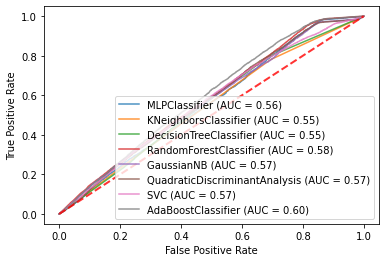

In [43]:
print("MODEL EVALUATION")

print("MLP Classifier Score:")
print("Score: {0} ==== F1: {1} ==== Jaccard: {2}".format(mlp_clf_score, mlp_f1, mlp_jaccard))
print("Confusion Matrix:")
print(confusion_matrix(y_test, mlp_clf_pred))
print()

print("KNN Classifier Score:")
print("Score: {0} ==== F1: {1} ==== Jaccard: {2}".format(knn_clf_score, knn_f1, knn_jaccard))
print("Confusion Matrix:")
print(confusion_matrix(y_test, knn_clf_pred))

print()

print("Decision Tree Classifier Score:")
print("Score: {0} ==== F1: {1} ==== Jaccard: {2}".format(tree_clf_score, tree_f1, tree_jaccard))
print("Confusion Matrix:")
print(confusion_matrix(y_test, tree_clf_pred))

print()

print("Random Forest Classifier Score:")
print("Score: {0} ==== F1: {1} ==== Jaccard: {2}".format(forest_clf_score, forest_f1, forest_jaccard))
print("Confusion Matrix:")
print(confusion_matrix(y_test, forest_clf_pred))

print()

print("Gaussian Naive Bays Score:")
print("Score: {0} ==== F1: {1} ==== Jaccard: {2}".format(nb_clf_score, nb_f1, nb_jaccard))
print("Confusion Matrix:")
print(confusion_matrix(y_test, nb_clf_pred))

print()

print("Quadratic Discriminant Analysis Score:")
print("Score: {0} ==== F1: {1} ==== Jaccard: {2}".format(qda_clf_score, qda_f1, qda_jaccard))
print("Confusion Matrix:")
print(confusion_matrix(y_test, qda_clf_pred))

print()

print("SVC Score:")
print("Score: {0} ==== F1: {1} ==== Jaccard: {2}".format(svc_clf_score, svc_f1, svc_jaccard))
print("Confusion Matrix:")
print(confusion_matrix(y_test, svc_clf_pred))

print()

print("AdaBoost Classifier Score:")
print("Score: {0} ==== F1: {1} ==== Jaccard: {2}".format(adaBoost_clf_score, adaBoost_f1, adaBoost_jaccard))
print("Confusion Matrix:")
print(confusion_matrix(y_test, adaBoost_clf_pred))
print()

ax = plt.gca()
mlp_disp = plot_roc_curve(mlp_clf, X_test, y_test, ax=ax, alpha=0.8)
knn_disp = plot_roc_curve(knn_clf, X_test, y_test, ax=ax, alpha=0.8)
tree_disp = plot_roc_curve(tree_clf, X_test, y_test, ax=ax, alpha=0.8)
forest_disp = plot_roc_curve(forest_clf, X_test, y_test, ax=ax, alpha=0.8)
nb_disp = plot_roc_curve(nb_clf, X_test, y_test, ax=ax, alpha=0.8)
qda_disp = plot_roc_curve(qda_clf, X_test, y_test,ax=ax, alpha=0.8)
svc_disp = plot_roc_curve(svc_clf, X_test, y_test,ax=ax, alpha=0.8)
adaBoost_disp = plot_roc_curve(adaBoost_clf, X_test, y_test,ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
plt.show()

### Validation:

The Multi-Layer Perceptron had the best overall results among the trained models. Therefore it is the model which is selected for retraining and validation

Retrained On: 65261  ====  Compared to 48945 Original Samples
==== MLP Classifier Training ====
Training Finished In: 6.788158893585205
MLP Classifier Score:
Score: 0.510573092246399 ==== F1: 0.6127358261797371 ==== Jaccard: 0.44168647741574607

Confusion Matrix:
[[6317 1816]
 [6169 2013]]



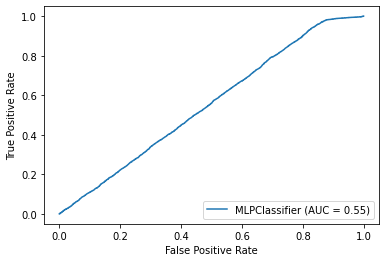

In [44]:

X_retrain = np.concatenate((X_train, X_test), axis=0)
y_retrain = np.concatenate((y_train, y_test), axis=0)


print("Retrained On: {0}  ====  Compared to {1} Original Samples".format(retrain_X.shape[0], X_train.shape[0]))

print("==== MLP Classifier Training ====")
start = time.time()
mlp_clf = MLPClassifier(random_state=1, max_iter=300).fit(X_retrain, y_retrain)
mlp_clf_score = mlp_clf.score(X_val, y_val)
mlp_clf_pred = mlp_clf.predict(X_val)
mlp_f1 = f1_score(y_val, mlp_clf_pred)
mlp_jaccard = jaccard_score(y_val, mlp_clf_pred)
matrix = confusion_matrix(y_val, mlp_clf_pred)

print("Training Finished In: {0}".format(abs(start - time.time())))
print("MLP Classifier Score:")
print("Score: {0} ==== F1: {1} ==== Jaccard: {2}".format(mlp_clf_score, mlp_f1, mlp_jaccard))
print()
print("Confusion Matrix:")
print(matrix)
print()
mlp_disp = plot_roc_curve(mlp_clf, X_val, y_val)

## Results and Discussion

This case study produced a number of ML models with varying performance. The model accuracies range from 50-57%, the F1 scores range from 30-70% and the jaccard indexes range from 0.2-0.5. The model which had the best balance of the three scores was the Multi-layer perceptron. The MLP classifier had a poorer accuracy score compared to the other model, but it had better F1 and jaccard scores. Another issue with the MLP is that it is very biased towards the "1" class. This is evident through the MLP confusion matrix.

Overall, the models do not perform very well. To inprove the model results, more feature engineering should be conducted.

## Conclusion

The purpose of this case study was to predict the risk of a vehicle collision based on road and weather conditions. The goal was to create a model which would help inform drivers about the current driving conditions, so that they can take the proper precautions to avoid a collision. For practical purposes, the models yielded from this investigation would not be satifactory. The models accuracies are only slightly better than a random guess, which is not sufficient for the application. To improve the model performance, another iteration of this investigation should be conducted and more feature engineering should be conducted. Overall, the case study provided a great experience to put together all of the skills acquired in this certificate program.